# Quick Start: Cytoland

**Estimated time to complete:** 15 minutes

# Learning Goals

* Download the VSCyto2D model and an example dataset containing A549 cell images.
* Run VSCyto2D model inference for joint virtual staining of cell nuclei and plasma membrane.
* Visualize and compare virtually and experimentally stained cells.

# Prerequisites
Python>=3.11

# Introduction

## Model

The Cytoland virtual staining models are a collection of models (VSCyto2D, VSCyto3D, and VSNeuromast)
used to predict cellular landmarks (e.g., nuclei and plasma membranes)
from label-free images (e.g. quantitative phase, Zernike phase contrast, and brightfield).
This quick-start guide focuses on the VSCyto2D model.

VSCyto2D is a 2D UNeXt2 model that has been trained on A549, HEK293T, and BJ-5ta cells.
This model enables users to jointly stain cell nuclei and plasma membranes from 2D label-free images
that are commonly generated for image-based screens.

Alternative models are optimized for different sample types and imaging conditions:

* [VSCyto3D](https://public.czbiohub.org/comp.micro/viscy/VS_models/VSCyto3D):
3D UNeXt2 model for joint virtual staining of cell nuclei and plasma membrane
from high-resolution volumetric images.
* [VSNeuromast](https://public.czbiohub.org/comp.micro/viscy/VS_models/VSNeuromast):
3D UNeXt2 model for joint virtual staining of nuclei and plasma membrane in zebrafish neuromasts.

## Example Dataset

The A549 example dataset used in this quick-start guide contains
quantitative phase and paired fluorescence images of cell nuclei and plasma membrane.
It is stored in OME-Zarr format and can be downloaded from
[here](https://public.czbiohub.org/comp.micro/viscy/VS_datasets/VSCyto2D/test/a549_hoechst_cellmask_test.zarr).
It has pre-computed statistics for normalization, generated using the `viscy preprocess` CLI.

Refer to our [preprint](https://doi.org/10.1101/2024.05.31.596901) for more details
about how the dataset and model were generated.

## User Data

The VSCyto2D model only requires label-free images for inference.
To run inference on your own data,
convert them into the OME-Zarr data format using iohub or other
[tools](https://ngff.openmicroscopy.org/tools/index.html#file-conversion),
and run [pre-processing](https://github.com/mehta-lab/VisCy/blob/main/docs/usage.md#preprocessing)
with the `viscy preprocess` CLI.

# Setup

The commands below will install the required packages and download the example dataset and model checkpoint.
It may take a few minutes to download all the files.

## Setup Google Colab

To run this quick-start guide using Google Colab,
choose the 'T4' GPU runtime from the "Connect" dropdown menu
in the upper-right corner of this notebook for faster execution.
Using a GPU significantly speeds up running model inference, but CPU compute can also be used.

## Setup Local Environment

The commands below assume a Unix-like shell with `wget` installed.
On Windows, the files can be downloaded manually from the URLs.

In [1]:
# Install VisCy with the optional dependencies for this example
# See the [repository](https://github.com/mehta-lab/VisCy) for more details
!pip install "viscy[metrics,visual]==0.3"

In [2]:
# restart kernel if running in Google Colab
if "get_ipython" in globals():
    session = get_ipython()
    if "google.colab" in str(session):
        print("Shutting down colab session.")
        session.kernel.do_shutdown(restart=True)

Shutting down colab session.


In [1]:
# Validate installation
!viscy --help

2025-06-17 14:59:40.008447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750172380.265658    1915 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750172380.335852    1915 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 14:59:40.866271: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
usage: viscy [-h] [-c CONFIG] [--print_config [=flags]]
             {fit,validate,test,predict,preprocess,export,pr

In [2]:
# Download the example dataset
!wget -m -np -nH --cut-dirs=5 -R "index.html*" "https://public.czbiohub.org/comp.micro/viscy/VS_datasets/VSCyto2D/test/a549_hoechst_cellmask_test.zarr/"
# Download the model checkpoint
!wget https://public.czbiohub.org/comp.micro/viscy/VS_models/VSCyto2D/VSCyto2D/epoch=399-step=23200.ckpt

Streaming output truncated to the last 5000 lines.
--2025-06-17 15:00:59--  https://public.czbiohub.org/comp.micro/viscy/VS_datasets/VSCyto2D/test/a549_hoechst_cellmask_test.zarr/0/0/30/0/0/2/0/?sort=name&order=desc
Reusing existing connection to public.czbiohub.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 14531 (14K) [text/html]
Saving to: ‘a549_hoechst_cellmask_test.zarr/0/0/30/0/0/2/0/index.html?sort=name&order=desc.tmp’

a549_hoechst_cellma 100%[===================>]  14.19K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2025-06-17 15:00:59 (269 MB/s) - ‘a549_hoechst_cellmask_test.zarr/0/0/30/0/0/2/0/index.html?sort=name&order=desc.tmp’ saved [14531/14531]

Removing a549_hoechst_cellmask_test.zarr/0/0/30/0/0/2/0/index.html?sort=name&order=desc.tmp since it should be rejected.

--2025-06-17 15:00:59--  https://public.czbiohub.org/comp.micro/viscy/VS_datasets/VSCyto2D/test/a549_hoechst_cellmask_test.zarr/0/0/30/0/0/2/0/?sort=time&

# Run Model Inference

The following code will run inference on a single field of view (FOV) of the example dataset.
This can also be achieved by using the VisCy CLI.

In [3]:
from pathlib import Path

from iohub import open_ome_zarr
from torchview import draw_graph

from viscy.data.hcs import HCSDataModule
from viscy.trainer import VisCyTrainer
from viscy.transforms import NormalizeSampled
from viscy.translation.engine import FcmaeUNet
from viscy.translation.predict_writer import HCSPredictionWriter



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [5]:
# NOTE: Nothing needs to be changed in this code block for the example to work.
# If using your own data, please modify the paths below.

# TODO: Set download paths, by default the working directory is used
root_dir = Path()
# TODO: modify the path to the input dataset
input_data_path = root_dir / "a549_hoechst_cellmask_test.zarr"
# TODO: modify the path to the model checkpoint
model_ckpt_path = root_dir / "epoch=399-step=23200.ckpt"
# TODO: modify the path to save the predictions
output_path = root_dir / "a549_prediction.zarr"
# TODO: Choose an FOV
fov = "0/0/0"

In [6]:
# Configure the data module for loading example images in prediction mode.
# See API documentation for how to use it with a different dataset.
# For example, View the documentation for the HCSDataModule class by running:
?HCSDataModule

In [7]:
# Setup the data module to use the example dataset
data_module = HCSDataModule(
    # Path to HCS or Single-FOV OME-Zarr dataset
    data_path=input_data_path / fov,
    # Name of the input phase channel
    source_channel="Phase3D",
    # Desired name of the output channels
    target_channel=["Membrane", "Nuclei"],
    # Axial input size, 1 for 2D models
    z_window_size=1,
    # Batch size
    # Adjust based on available memory (reduce if seeing OOM errors)
    batch_size=8,
    # Number of workers for data loading
    # Set to 0 for Windows and macOS if running in a notebook,
    # since multiprocessing only works with a `if __name__ == '__main__':` guard.
    # On Linux, set it based on available CPU cores to maximize performance.
    num_workers=4,
    # Normalization strategy
    # This one uses pre-computed statistics from `viscy preprocess`
    # to subtract the median and divide by the interquartile range (IQR).
    # It can also be replaced by other MONAI transforms.
    normalizations=[
        NormalizeSampled(
            ["Phase3D"],
            level="fov_statistics",
            subtrahend="median",
            divisor="iqr",
        )
    ],
)

In [8]:
# Load the VSCyto2D model from the downloaded checkpoint
# VSCyto2D is fine-tuned from a FCMAE-pretrained UNeXt2 model.
# See this module for options to configure the model:
from viscy.unet.networks.fcmae import FullyConvolutionalMAE

?FullyConvolutionalMAE

In [9]:
vs_cyto_2d = FcmaeUNet.load_from_checkpoint(
    # checkpoint path
    model_ckpt_path,
    model_config={
        # number of input channels
        # must match the number of channels in the input data
        "in_channels": 1,
        # number of output channels
        # must match the number of target channels in the data module
        "out_channels": 2,
        # number of ConvNeXt v2 blocks in each stage of the encoder
        "encoder_blocks": [3, 3, 9, 3],
        # feature map channels in each stage of the encoder
        "dims": [96, 192, 384, 768],
        # number of ConvNeXt v2 blocks in each stage of the decoder
        "decoder_conv_blocks": 2,
        # kernel size in the stem layer
        "stem_kernel_size": [1, 2, 2],
        # axial size of the input image
        # must match the Z-window size in the data module
        "in_stack_depth": 1,
        # whether to perform masking (for FCMAE pre-training)
        "pretraining": False,
    },
)

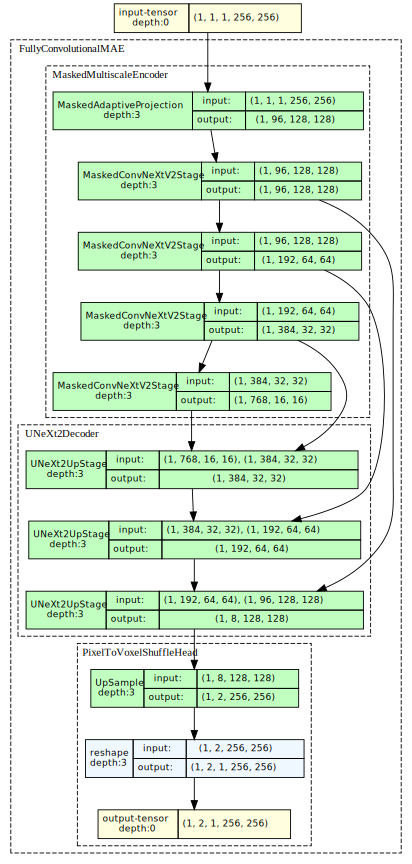

In [10]:
# Visualize the model graph
model_graph = draw_graph(
    vs_cyto_2d,
    (vs_cyto_2d.example_input_array),
    graph_name="VSCyto2D",
    roll=True,
    depth=3,
    expand_nested=True,
)

model_graph.visual_graph

In [11]:
# Setup the trainer for prediction
# The trainer can be further configured to better utilize the available hardware,
# For example using GPUs and half precision.
# Callbacks can also be used to customize logging and prediction writing.
# See the API documentation for more details:
?VisCyTrainer

In [12]:
# Initialize the trainer
# The prediction writer callback will save the predictions to an OME-Zarr store
trainer = VisCyTrainer(callbacks=[HCSPredictionWriter(output_path)])

# Run prediction
trainer.predict(model=vs_cyto_2d, datamodule=data_module, return_predictions=False)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker

Predicting: |          | 0/? [00:00<?, ?it/s]

# Model Outputs

The model outputs are also stored in an OME-Zarr store.
It can be visualized in an image viewer such as [napari](https://napari.org/).
Below we show a snapshot in the notebook.

In [13]:
# Read images from Zarr stores
# Choose the ROI for better visualization
y_slice = slice(0, 512)
x_slice = slice(0, 512)

# Open the prediction store and get the 2D images from 5D arrays (t,c,z,y,x)
with open_ome_zarr(output_path / fov) as vs_store:
    vs_nucleus = vs_store[0][0, 0, 0, y_slice, x_slice]
    vs_membrane = vs_store[0][0, 1, 0, y_slice, x_slice]

# Open the experimental fluorescence dataset
with open_ome_zarr(input_data_path / fov) as fluor_store:
    fluor_nucleus = fluor_store[0][0, 1, 0, y_slice, x_slice]
    fluor_membrane = fluor_store[0][0, 2, 0, y_slice, x_slice]

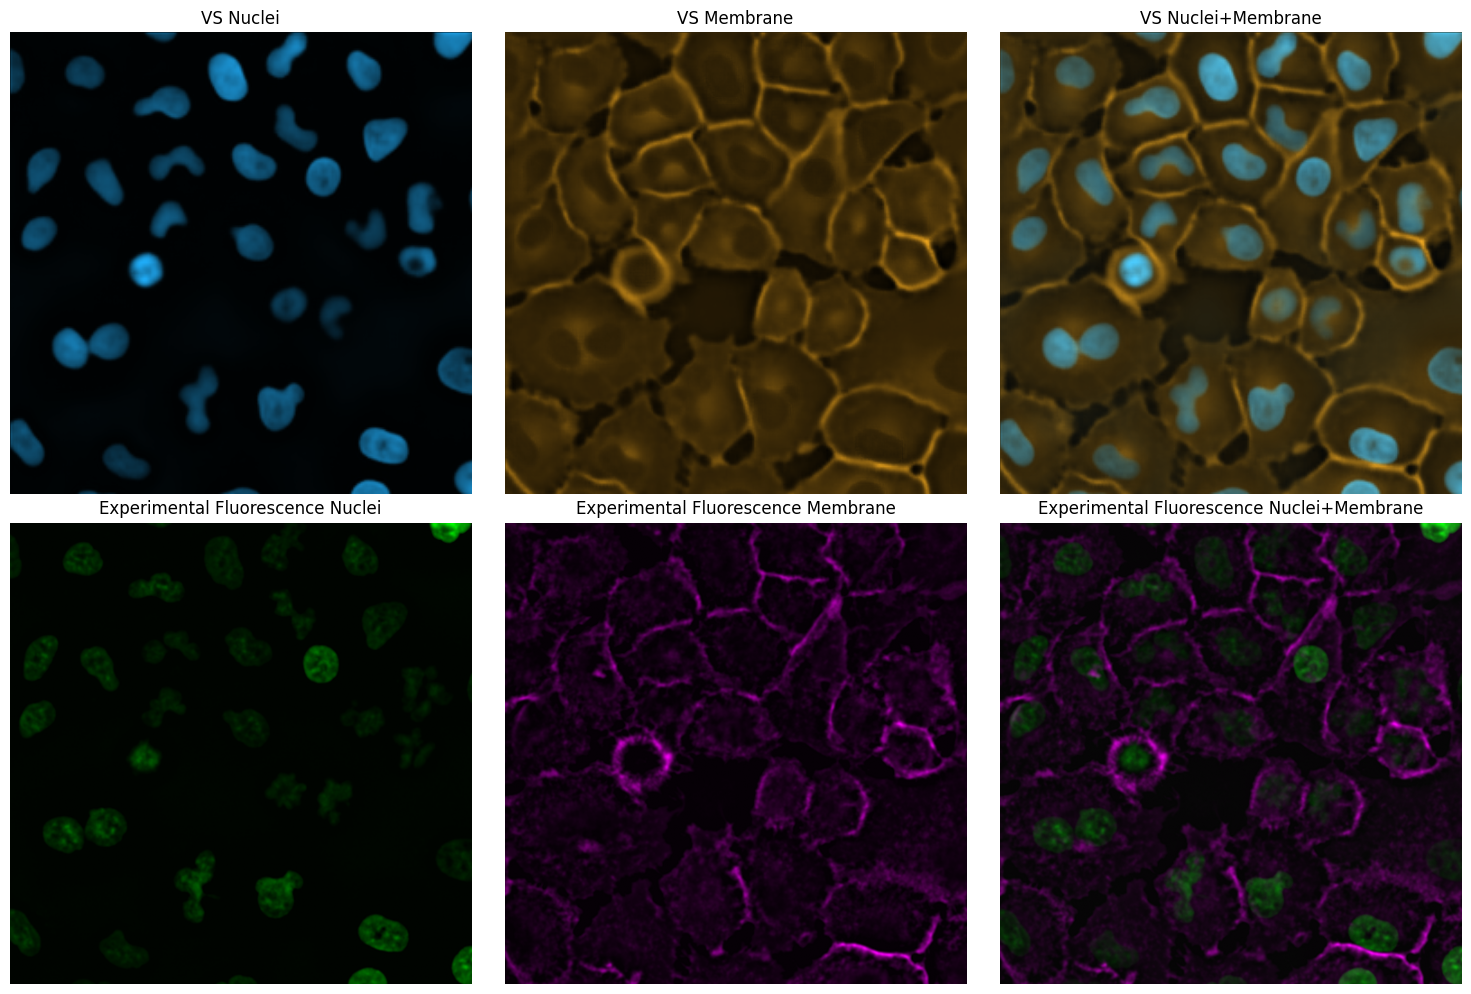

In [14]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
from cmap import Colormap
from skimage.exposure import rescale_intensity


def render_rgb(image: np.ndarray, colormap: Colormap):
    image = rescale_intensity(image, out_range=(0, 1))
    image = colormap(image)
    return image


# Render the images as RGB in false colors
vs_nucleus_rgb = render_rgb(vs_nucleus, Colormap("bop_blue"))
vs_membrane_rgb = render_rgb(vs_membrane, Colormap("bop_orange"))
merged_vs = (vs_nucleus_rgb + vs_membrane_rgb).clip(0, 1)

fluor_nucleus_rgb = render_rgb(fluor_nucleus, Colormap("green"))
fluor_membrane_rgb = render_rgb(fluor_membrane, Colormap("magenta"))
merged_fluor = (fluor_nucleus_rgb + fluor_membrane_rgb).clip(0, 1)

# Plot
# Show the individual channels and then fused in a grid
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Virtual staining plots
ax[0, 0].imshow(vs_nucleus_rgb)
ax[0, 0].set_title("VS Nuclei")
ax[0, 1].imshow(vs_membrane_rgb)
ax[0, 1].set_title("VS Membrane")
ax[0, 2].imshow(merged_vs)
ax[0, 2].set_title("VS Nuclei+Membrane")

# Experimental fluorescence plots
ax[1, 0].imshow(fluor_nucleus_rgb)
ax[1, 0].set_title("Experimental Fluorescence Nuclei")
ax[1, 1].imshow(fluor_membrane_rgb)
ax[1, 1].set_title("Experimental Fluorescence Membrane")
ax[1, 2].imshow(merged_fluor)
ax[1, 2].set_title("Experimental Fluorescence Nuclei+Membrane")

# turnoff axis
for a in ax.flatten():
    a.axis("off")
plt.tight_layout()
plt.show()

## Responsible Use

We are committed to advancing the responsible development and use of artificial intelligence.
Please follow our [Acceptable Use Policy](https://virtualcellmodels.cziscience.com/acceptable-use-policy) when engaging with our services.

Should you have any security or privacy issues or questions related to the services,
please reach out to our team at [security@chanzuckerberg.com](mailto:security@chanzuckerberg.com) or [privacy@chanzuckerberg.com](mailto:privacy@chanzuckerberg.com) respectively.